In [2]:
# Import packages
import pandas as pd
import numpy as np
import seaborn as sns
import patsy
import scipy.stats as stats
import pickle

import statsmodels.api as sm
import statsmodels.formula.api as smf
from sklearn import preprocessing
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt
%matplotlib inline

/anaconda3/lib/python3.7/site-packages/statsmodels/compat/pandas.py:49: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  data_klasses = (pandas.Series, pandas.DataFrame, pandas.Panel)


# Valence list imports

In [3]:
# Import valence datasets. These are txt files with large lists of pos/neg valence words. Will use these lists as a way to check the valence of rental descriptions
pos_valence_data = pd.read_csv(
    '/Users/alentersakyan/GitHub/Metis-Project-2/Pos_Valence.txt')
neg_valence_data = pd.read_csv(
    '/Users/alentersakyan/GitHub/Metis-Project-2/Neg_Valence.txt')

In [4]:
# Examine valence datasets to ensure correct parsing
print(pos_valence_data.head())
print(neg_valence_data.head())

  Positive Words
0             a+
1         abound
2        abounds
3      abundance
4       abundant
  Negative Words
0        2-faced
1        2-faces
2       abnormal
3        abolish
4     abominable


In [7]:
# Import main dataset
df = pd.read_csv('/Users/alentersakyan/GitHub/Metis-Project-2/data.csv')

In [8]:
# # To load pickle back in
# with open('nyc_df_final.pickle','rb') as read_file:
#       df = pickle.load(read_file)

In [5]:
df.columns

Index(['id', 'log_price', 'property_type', 'room_type', 'amenities',
       'accommodates', 'bathrooms', 'bed_type', 'cancellation_policy',
       'cleaning_fee', 'city', 'description', 'first_review',
       'host_has_profile_pic', 'host_identity_verified', 'host_response_rate',
       'host_since', 'instant_bookable', 'last_review', 'latitude',
       'longitude', 'name', 'neighbourhood', 'number_of_reviews',
       'review_scores_rating', 'thumbnail_url', 'zipcode', 'bedrooms', 'beds'],
      dtype='object')

In [7]:
df.cancellation_policy.value_counts()

strict             32374
flexible           22545
moderate           19063
super_strict_30      112
super_strict_60       17
Name: cancellation_policy, dtype: int64

In [8]:
#df.latitude

In [9]:
df.city.value_counts()

NYC        32349
LA         22453
SF          6434
DC          5688
Chicago     3719
Boston      3468
Name: city, dtype: int64

# Select only NYC

In [10]:
nyc_df = df[df['city'] == 'NYC']
nyc_df.shape

(32349, 29)

#### Which features do I want to work with? Which ones are problematic?

In [11]:
nyc_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 32349 entries, 0 to 74109
Data columns (total 29 columns):
id                        32349 non-null int64
log_price                 32349 non-null float64
property_type             32349 non-null object
room_type                 32349 non-null object
amenities                 32349 non-null object
accommodates              32349 non-null int64
bathrooms                 32250 non-null float64
bed_type                  32349 non-null object
cancellation_policy       32349 non-null object
cleaning_fee              32349 non-null bool
city                      32349 non-null object
description               32349 non-null object
first_review              25491 non-null object
host_has_profile_pic      32173 non-null object
host_identity_verified    32173 non-null object
host_response_rate        22389 non-null object
host_since                32173 non-null object
instant_bookable          32349 non-null object
last_review               255

In [12]:
pd.set_option('display.max_colwidth', 0)
nyc_df[['property_type','room_type','bed_type','cancellation_policy',
      'cleaning_fee','city','host_has_profile_pic','host_identity_verified',
     'host_response_rate','instant_bookable','neighbourhood']].agg(['unique']).transpose()

,unique
property_type,"[Apartment, House, Loft, Hostel, Condominium, Townhouse, Other, Bed & Breakfast, Timeshare, Serviced apartment, Guesthouse, Bungalow, Boutique hotel, Guest suite, Boat, Villa, Dorm, Vacation home, In-law, Chalet, Yurt, Cabin, Tent, Earth House, Castle]"
room_type,"[Entire home/apt, Private room, Shared room]"
bed_type,"[Real Bed, Futon, Pull-out Sofa, Airbed, Couch]"
cancellation_policy,"[strict, moderate, flexible, super_strict_30, super_strict_60]"
cleaning_fee,"[True, False]"
city,[NYC]
host_has_profile_pic,"[t, nan, f]"
host_identity_verified,"[t, f, nan]"
host_response_rate,"[nan, 100%, 71%, 68%, 67%, 90%, 86%, 92%, 80%, 89%, 0%, 50%, 70%, 25%, 29%, 93%, 33%, 81%, 63%, 38%, 60%, 88%, 78%, 75%, 95%, 97%, 94%, 40%, 58%, 76%, 91%, 79%, 82%, 30%, 83%, 87%, 99%, 17%, 20%, 77%, 96%, 73%, 98%, 59%, 57%, 64%, 56%, 44%, 74%, 27%, 6%, 85%, 10%, 55%, 43%, 14%, 84%, 46%, 26%, 53%, 65%, 52%, 22%, 69%, 66%, 15%, 61%, 41%, 72%, 54%, 35%, 36%, 62%, 21%, 47%]"
instant_bookable,"[f, t]"


# Examine each feature a little closer

In [13]:
# There is a zero price-- need to delete
# anti log is 10 ^ log price to get original
nyc_df.log_price.describe()

count    32349.000000
mean     4.719340    
std      0.661567    
min      0.000000    
25%      4.248495    
50%      4.653960    
75%      5.164786    
max      7.600402    
Name: log_price, dtype: float64

In [14]:
nyc_df['log_price'] = nyc_df['log_price'][(nyc_df['log_price'] != 0)] # drop zeros
nyc_df.log_price.describe()

/anaconda3/envs/metis/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


count    32348.000000
mean     4.719486    
std      0.661057    
min      1.609438    
25%      4.248495    
50%      4.653960    
75%      5.164786    
max      7.600402    
Name: log_price, dtype: float64

# Combine random property types to "other"

In [15]:
# Lots of kinds of properties so I need to combine a few. Tons in apartment cat, so won't add things to that,
# but rather add to "other" category
nyc_df['property_type'].value_counts()

Apartment             27485
House                 2690 
Loft                  631  
Townhouse             598  
Condominium           425  
Other                 204  
Bed & Breakfast       95   
Timeshare             44   
Guest suite           39   
Guesthouse            32   
Boutique hotel        16   
Hostel                16   
Dorm                  15   
Villa                 13   
Bungalow              12   
Serviced apartment    8    
Boat                  6    
Vacation home         6    
In-law                4    
Chalet                3    
Cabin                 3    
Earth House           1    
Yurt                  1    
Tent                  1    
Castle                1    
Name: property_type, dtype: int64

In [16]:
property_dict = {'Other': ['Other', 'Loft', 'Townhouse', 'Condominium', 'Bed & Breakfast', 'Timeshare', 'Guest suite', \
                          'Guesthouse', 'Hostel', 'Boutique hotel', 'Dorm', 'Villa', 'Bungalow', 'Serviced apartment', \
                          'Vacation home', 'Boat', 'In-law', 'Chalet', 'Cabin', 'Castle', 'Yurt', 'Tent', 'Earth House']}

In [17]:
# Renaming everything from property_dict to "Other"
# First loop through k,v in prop dict, then for items within the values, then set items to key ('Other')
dict2 = {i : k for k, v in property_dict.items() for i in v}

In [18]:
dict2

{'Other': 'Other',
 'Loft': 'Other',
 'Townhouse': 'Other',
 'Condominium': 'Other',
 'Bed & Breakfast': 'Other',
 'Timeshare': 'Other',
 'Guest suite': 'Other',
 'Guesthouse': 'Other',
 'Hostel': 'Other',
 'Boutique hotel': 'Other',
 'Dorm': 'Other',
 'Villa': 'Other',
 'Bungalow': 'Other',
 'Serviced apartment': 'Other',
 'Vacation home': 'Other',
 'Boat': 'Other',
 'In-law': 'Other',
 'Chalet': 'Other',
 'Cabin': 'Other',
 'Castle': 'Other',
 'Yurt': 'Other',
 'Tent': 'Other',
 'Earth House': 'Other'}

In [19]:
# Apply name change to df
nyc_df['property_type'].replace(dict2,inplace=True)

/anaconda3/envs/metis/lib/python3.7/site-packages/pandas/core/generic.py:6786: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._update_inplace(new_data)


In [20]:
# Value counts to ensure we applied change correctly
# Maybe in the end model apartments separately? 
nyc_df.property_type.value_counts()

Apartment    27485
House        2690 
Other        2174 
Name: property_type, dtype: int64

In [21]:
nyc_df.columns

Index(['id', 'log_price', 'property_type', 'room_type', 'amenities',
       'accommodates', 'bathrooms', 'bed_type', 'cancellation_policy',
       'cleaning_fee', 'city', 'description', 'first_review',
       'host_has_profile_pic', 'host_identity_verified', 'host_response_rate',
       'host_since', 'instant_bookable', 'last_review', 'latitude',
       'longitude', 'name', 'neighbourhood', 'number_of_reviews',
       'review_scores_rating', 'thumbnail_url', 'zipcode', 'bedrooms', 'beds'],
      dtype='object')

# Remove spaces from bed_type

In [22]:
nyc_df.bed_type.value_counts()

Real Bed         31414
Futon            366  
Pull-out Sofa    293  
Airbed           185  
Couch            91   
Name: bed_type, dtype: int64

In [23]:
nyc_df.bed_type = nyc_df.bed_type.str.replace(' ', '_')

/anaconda3/envs/metis/lib/python3.7/site-packages/pandas/core/generic.py:5208: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value


In [24]:
nyc_df.bed_type.value_counts()

Real_Bed         31414
Futon            366  
Pull-out_Sofa    293  
Airbed           185  
Couch            91   
Name: bed_type, dtype: int64

In [25]:
nyc_df.room_type.value_counts()

Entire home/apt    16243
Private room       15299
Shared room        807  
Name: room_type, dtype: int64

# Remove spaces from room type variables

In [26]:
nyc_df['room_type'] = nyc_df['room_type'].str.replace(' ', '_')

/anaconda3/envs/metis/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [27]:
nyc_df.room_type.value_counts()

Entire_home/apt    16243
Private_room       15299
Shared_room        807  
Name: room_type, dtype: int64

In [28]:
nyc_df.number_of_reviews.describe()

count    32349.000000
mean     18.121209   
std      32.852804   
min      0.000000    
25%      1.000000    
50%      5.000000    
75%      20.000000   
max      474.000000  
Name: number_of_reviews, dtype: float64

In [29]:
nyc_df.property_type.value_counts()

Apartment    27485
House        2690 
Other        2174 
Name: property_type, dtype: int64

In [30]:
nyc_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 32349 entries, 0 to 74109
Data columns (total 29 columns):
id                        32349 non-null int64
log_price                 32348 non-null float64
property_type             32349 non-null object
room_type                 32349 non-null object
amenities                 32349 non-null object
accommodates              32349 non-null int64
bathrooms                 32250 non-null float64
bed_type                  32349 non-null object
cancellation_policy       32349 non-null object
cleaning_fee              32349 non-null bool
city                      32349 non-null object
description               32349 non-null object
first_review              25491 non-null object
host_has_profile_pic      32173 non-null object
host_identity_verified    32173 non-null object
host_response_rate        22389 non-null object
host_since                32173 non-null object
instant_bookable          32349 non-null object
last_review               255

In [31]:
nyc_df.cleaning_fee.value_counts()

True     22889
False    9460 
Name: cleaning_fee, dtype: int64

# Most hosts have prof pic so won't put in model

In [1]:
# Most of them have profile pic so likely will not use this
nyc_df.host_has_profile_pic.value_counts()

NameError: name 'nyc_df' is not defined

In [33]:
nyc_df['host_has_profile_pic'].fillna('f', inplace=True)
nyc_df.host_has_profile_pic.value_counts()

/anaconda3/envs/metis/lib/python3.7/site-packages/pandas/core/generic.py:6287: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._update_inplace(new_data)


t    32076
f    273  
Name: host_has_profile_pic, dtype: int64

In [34]:
nyc_df['host_identity_verified'].fillna('f', inplace=True)

In [35]:
nyc_df['review_scores_rating'].describe()

count    25028.000000
mean     93.506553   
std      8.200527    
min      20.000000   
25%      91.000000   
50%      96.000000   
75%      100.000000  
max      100.000000  
Name: review_scores_rating, dtype: float64

# Review score: Need to replace review scores with median before doing the > 70 cutoff

Checked the median for each property_type (other, apt, house) to see if I could more efficiently impute median-- that is, could I apply median for each subgroup. They are 95,96,97 so no big diff. Will just impute group median

In [37]:
print(nyc_df.review_scores_rating[nyc_df['property_type'] == 'Other'].median())
print(nyc_df.review_scores_rating[nyc_df['property_type'] == 'Apartment'].median())
print(nyc_df.review_scores_rating[nyc_df['property_type'] == 'House'].median())
print(nyc_df['review_scores_rating'].median())

97.0
96.0
95.0
96.0


In [38]:
nyc_df['review_scores_rating'].fillna(nyc_df['review_scores_rating'].median(), inplace=True)

In [39]:
# Make sure effects took place
nyc_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 32349 entries, 0 to 74109
Data columns (total 29 columns):
id                        32349 non-null int64
log_price                 32348 non-null float64
property_type             32349 non-null object
room_type                 32349 non-null object
amenities                 32349 non-null object
accommodates              32349 non-null int64
bathrooms                 32250 non-null float64
bed_type                  32349 non-null object
cancellation_policy       32349 non-null object
cleaning_fee              32349 non-null bool
city                      32349 non-null object
description               32349 non-null object
first_review              25491 non-null object
host_has_profile_pic      32349 non-null object
host_identity_verified    32349 non-null object
host_response_rate        22389 non-null object
host_since                32173 non-null object
instant_bookable          32349 non-null object
last_review               255

In [40]:
#nyc_df.review_scores_rating.plot(kind='hist',bins=10)

In [41]:
# Examine review scores
#nyc_df.review_scores_rating.value_counts(sort=True, ascending=True)

In [42]:
# Keep only those with higher than 70 review score
nyc_df = nyc_df[nyc_df.review_scores_rating >= 70.0]

In [43]:
#nyc_df.review_scores_rating.value_counts(sort=True, ascending=True)

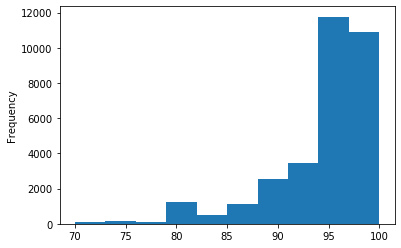

In [44]:
nyc_df.review_scores_rating.plot(kind='hist', bins=10)

### Boxcox transform the review scores since they are skewed... not sure if I like the result. Might not use this

Lambda: 10.6721756122339


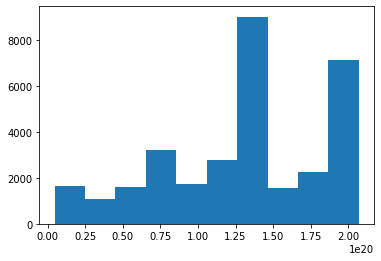

In [45]:
lamb=stats.boxcox_normmax(nyc_df.review_scores_rating, brack=(-1.9, 1.9)) # don't use "lambda" as it's a Python reserved word
print("Lambda:", lamb)

# Get new Y with new power transform
review_score_bct=(np.power(nyc_df.review_scores_rating,lamb)-1)/lamb # putting in lamb for plugin

plt.hist(review_score_bct);

# There are many 'amenities' with "translation missing: en.hosting_amenity_50", might need to clean that up

In [46]:
#nyc_df['amenities_count'] = nyc_df['amenities'].apply(lambda amenities: len(amenities.split(',')))

In [47]:
######x['amenities_trimmed'] = x['amenities'].apply(lambda amenities: len(amenities.split(',')))

In [48]:
# test = nyc_df.amenities[0]
# print(test)

In [49]:
def amenity_count(amenities):
    '''Clean up amenities (remove below string), then count. This does not change the\
amenities column in place, but rather a tmp list, then counts length of temp list'''

    if amenities.split(',')[-1] == '"translation missing: en.hosting_amenity_50"}':
        tmp = amenities.split(',')
        del tmp[-1]
    else:
        tmp = amenities.split(',')
    return len(tmp)

In [50]:
nyc_df['amenity_count'] = nyc_df['amenities'].apply(amenity_count)

In [51]:
nyc_df.amenity_count.describe()

count    31913.000000
mean     16.205120   
std      7.209432    
min      1.000000    
25%      12.000000   
50%      15.000000   
75%      20.000000   
max      77.000000   
Name: amenity_count, dtype: float64

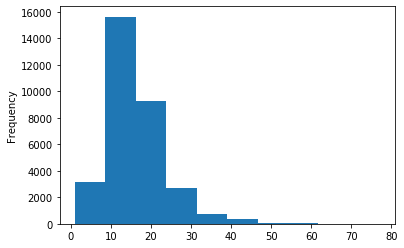

In [52]:
nyc_df.amenity_count.plot(kind='hist')

In [53]:
print("stdv amenities count = ", nyc_df.amenity_count.std())
print("mean amenities count = ", nyc_df.amenity_count.mean())
print("mean  + 2SD of amenities count = ~ 40")
print("median amenities count = ", nyc_df.amenity_count.median())

stdv amenities count =  7.209432110879009
mean amenities count =  16.20512017046345
mean  + 2SD of amenities count = ~ 40
median amenities count =  15.0


#### I will delete all amenities count > 40

In [54]:
nyc_df = nyc_df[nyc_df['amenity_count'] < 40.0]

In [55]:
nyc_df.describe()

,id,log_price,accommodates,bathrooms,latitude,longitude,number_of_reviews,review_scores_rating,bedrooms,beds,amenity_count
count,3.151900e+04,31518.000000,31519.000000,31422.000000,31519.000000,31519.000000,31519.000000,31519.000000,31473.000000,31459.000000,31519.000000
mean,1.127011e+07,4.717960,2.801675,1.128859,40.730215,-73.954933,18.159015,94.601732,1.155276,1.547538,15.836575
std,6.074222e+06,0.658197,1.834456,0.396479,0.053719,0.042217,32.851439,5.428359,0.717150,1.047958,6.413653
min,2.404000e+03,1.609438,1.000000,0.000000,40.499794,-74.253269,0.000000,70.000000,0.000000,0.000000,1.000000
25%,6.259848e+06,4.248495,2.000000,1.000000,40.691339,-73.983624,1.000000,93.000000,1.000000,1.000000,11.000000
50%,1.227277e+07,4.653960,2.000000,1.000000,40.723890,-73.956834,5.000000,96.000000,1.000000,1.000000,15.000000
75%,1.639777e+07,5.164786,4.000000,1.000000,40.764132,-73.939634,20.000000,98.000000,1.000000,2.000000,19.000000
max,2.122836e+07,7.600402,16.000000,8.000000,40.909174,-73.710126,474.000000,100.000000,10.000000,18.000000,39.000000


# Number of reviews- lots on the low end

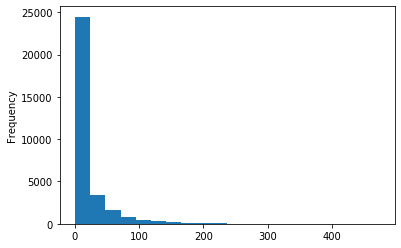

In [56]:
nyc_df.number_of_reviews.plot(kind='hist', bins=20)

## Many places with zero reviews

In [57]:
nyc_df.number_of_reviews.value_counts()

0      6800
1      3202
2      2292
3      1765
4      1301
       ... 
264    1   
280    1   
296    1   
217    1   
295    1   
Name: number_of_reviews, Length: 279, dtype: int64

# Read wiki table for top NYC destinations
- Will use Beautiful Soup in other notebook. For now pd.read_html works well.

In [58]:
wiki_url = 'https://en.wikipedia.org/wiki/Tourism_in_New_York_City'

In [59]:
tables_pd = pd.read_html(wiki_url)

In [60]:
tourist_dest = tables_pd[1]

In [61]:
tourist_dest['Name']

0     Central Park                                          
1     Times Square                                          
2     Grand Central Terminal                                
3     Theater District (including Broadway theatres)        
4     Rockefeller Center (including Top of the Rock)        
5     Bryant Park                                           
6     Prospect Park                                         
7     South Street Seaport                                  
8     High Line                                             
9     Coney Island (including amusement parks and boardwalk)
10    National September 11 Memorial                        
11    Metropolitan Museum of Art                            
12    Rockaway Beach                                        
13    American Museum of Natural History                    
14    Statue of Liberty and Ellis Island                    
15    Empire State Building                                 
16    National September

In [62]:
# Make description col lowercase
nyc_df.description = nyc_df.description.str.lower()

In [63]:
test_list = ['brooklyn bridge', 'brooklyn bridge']

# Search a list (of tourist dests) to see if ANY are mentioned, not necessarily count of how many. I think any is OK for this model

In [64]:
mention_tourism = 0
if any(x in nyc_df.description[1] for x in test_list):
    print('yes')
    mention_tourism +=1

In [65]:
mention_tourism

0

# Tourism mentions counter

In [66]:
def count_tourism_mentions(description_column):
    '''Search description column for mentions of top tourism locations in NY.\
    Data for tourist dests taken from scraped wiki table. Assumes description col of main df\
    has been made lower(). HOWEVER THIS DOES NOT WORK IF clean_txt function has been applied-- which\
    makes the desc into a list. This only works if desc is a string. Must run before valence count fx\
    which relies on it being a list'''
    tourism_mentions = 0
    for x in tourist_dest.Name.str.lower(): # search tourist dest df
        if description_column.__contains__(x):
            tourism_mentions += 1
    nyc_df['tourism_mentions'] = tourism_mentions
    return tourism_mentions

In [67]:
# mentions = 0
# for x in tourist_dest.Name.str.lower():
#     if nyc_df.description[1].__contains__(x):
#         mentions +=1
#         print(x)
# print(mentions)

In [69]:
#test_tourism_df = nyc_df[0:22].copy()

In [70]:
nyc_df['tourism_mentions'] = nyc_df['description'].apply(count_tourism_mentions)

In [71]:
nyc_df['tourism_mentions'].describe()

count    31519.000000
mean     0.332783    
std      0.602426    
min      0.000000    
25%      0.000000    
50%      0.000000    
75%      1.000000    
max      5.000000    
Name: tourism_mentions, dtype: float64

### Do I want to make this mention/ not mention? Very low variance as scale variable...

In [72]:
nyc_df['tourism_mentions'].value_counts()

0    22938
1    6953 
2    1378 
3    222  
4    26   
5    2    
Name: tourism_mentions, dtype: int64

# Apply valence count to nyc_df

- Description has been stripped and lower-case already at this point

# Had this in the original models, but now leaving out when remaking df with zipcode-- takes a while to run so skipping

In [94]:
# def valence_count(description_column):
#     '''Get valence count (how positive) for the descriptions the hosts write. This works by matching\
#     the words in the description to online lists of pos/neg valence words'''
#     pos_count = 0
#     neg_count = 0
#     #words = df['description'].iteritems()
#     for word in description_column: # words = description so need to make this iterate
#         num_pos_matches = pos_valence_data[pos_valence_data['Positive Words'] == word].shape[0]
#         if num_pos_matches > 0:
#             pos_count += 1
#         num_neg_matches = neg_valence_data[neg_valence_data['Negative Words'] == word].shape[0]
#         if num_neg_matches > 0:
#             neg_count += 1
#     total_count = pos_count - neg_count
#     return total_count

### Clean description text, split, make lower (clean_text function)

In [74]:
def clean_text(s):
    '''Function to clean up special chars from strings, and make lower case'''
    for c in ['{','}', '!','"', ",", ':', '/', "&", "-", "(", ")", "."]:
        s=s.replace(c,'').lower()
    return s.split(' ')

In [75]:
nyc_df['description'] = nyc_df['description'].apply(clean_text)

In [76]:
nyc_df['description']

0        [beautiful, sunlit, brownstone, 1bedroom, in, the, loveliest, neighborhood, in, brooklyn, blocks, from, the, promenade, and, brooklyn, bridge, park, with, their, stunning, views, of, manhattan, and, from, the, great, shopping, and, food]                                                                                                                                                                                                                                                                                                                                                                                                                                                                                            
1        [enjoy, travelling, during, your, stay, in, manhattan, my, place, is, centrally, located, near, times, square, and, central, park, with, easy, access, to, main, subways, as, well, as, walking, distance, to, many, popular, restaurants, and, bus, tours, my, place, is, c

# Test to make sure valence count is working on smaller DF before running very long process overnight

In [98]:
#test_df = nyc_df[0:22].copy()

In [99]:
#test_df.shape

(22, 31)

In [100]:
#test_df.description

0     [beautiful, sunlit, brownstone, 1bedroom, in, the, loveliest, neighborhood, in, brooklyn, blocks, from, the, promenade, and, brooklyn, bridge, park, with, their, stunning, views, of, manhattan, and, from, the, great, shopping, and, food]                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                            
1     [enjoy, travelling, during, your, stay, in, manhattan, my, place, is, centrally, located, near, times, square, and, central, park, with, easy, access, to, main, subways, as, well, as, walking, distance, to, many, popular, restaurants, and, bus, tours, my, pl

In [101]:
#test_df['valence_count'] = test_df['description'].apply(valence_count)

In [102]:
#test_df['valence_count']

0     3 
1     9 
2     6 
10    10
18    18
19    2 
21    5 
27    5 
29    5 
30    5 
35    5 
37    0 
38    12
45    9 
47    4 
48    5 
49    8 
51    8 
54    1 
55    2 
56    2 
57    6 
Name: valence_count, dtype: int64

In [103]:
#test_df['description'][0]

['beautiful',
 'sunlit',
 'brownstone',
 '1bedroom',
 'in',
 'the',
 'loveliest',
 'neighborhood',
 'in',
 'brooklyn',
 'blocks',
 'from',
 'the',
 'promenade',
 'and',
 'brooklyn',
 'bridge',
 'park',
 'with',
 'their',
 'stunning',
 'views',
 'of',
 'manhattan',
 'and',
 'from',
 'the',
 'great',
 'shopping',
 'and',
 'food']

In [81]:
# Make sure in correct format before running-- must have gone through 'clean_text' fx
#nyc_df['description']

In [104]:
#nyc_df['valence_total'] = nyc_df['description'].apply(valence_count)

In [115]:
#nyc_df['valence_total'].describe()

count    31519.000000
mean     7.302135    
std      4.461943    
min     -6.000000    
25%      4.000000    
50%      7.000000    
75%      10.000000   
max      38.000000   
Name: valence_total, dtype: float64

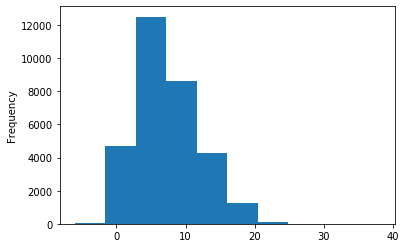

In [123]:
#nyc_df['valence_total'].plot(kind='hist',bins=10)

### Since the valence count is computationally heavy, pickle the df here so I don't have to reload that part

In [78]:
with open ('df_with_zip_no_valence.pickle', 'wb') as to_write:
    pickle.dump(nyc_df, to_write)

In [80]:
# To load pickle back in
with open('df_with_zip_no_valence.pickle','rb') as read_file:
      nyc_df_model = pickle.load(read_file)

In [320]:
# When needed to revert, del the new df
#del nyc_df_model

In [81]:
nyc_df_model.head()

,id,log_price,property_type,room_type,amenities,accommodates,bathrooms,bed_type,cancellation_policy,cleaning_fee,...,name,neighbourhood,number_of_reviews,review_scores_rating,thumbnail_url,zipcode,bedrooms,beds,amenity_count,tourism_mentions
0,6901257,5.010635,Apartment,Entire_home/apt,"{""Wireless Internet"",""Air conditioning"",Kitchen,Heating,""Family/kid friendly"",Essentials,""Hair dryer"",Iron,""translation missing: en.hosting_amenity_50""}",3,1.0,Real_Bed,strict,True,...,Beautiful brownstone 1-bedroom,Brooklyn Heights,2,100.0,https://a0.muscache.com/im/pictures/6d7cbbf7-c034-459c-bc82-6522c957627c.jpg?aki_policy=small,11201,1.0,1.0,8,0
1,6304928,5.129899,Apartment,Entire_home/apt,"{""Wireless Internet"",""Air conditioning"",Kitchen,Heating,""Family/kid friendly"",Washer,Dryer,""Smoke detector"",""Fire extinguisher"",Essentials,Shampoo,Hangers,""Hair dryer"",Iron,""translation missing: en.hosting_amenity_50""}",7,1.0,Real_Bed,strict,True,...,Superb 3BR Apt Located Near Times Square,Hell's Kitchen,6,93.0,https://a0.muscache.com/im/pictures/348a55fe-4b65-452a-b48a-bfecb3b58a66.jpg?aki_policy=small,10019,3.0,3.0,14,3
2,7919400,4.976734,Apartment,Entire_home/apt,"{TV,""Cable TV"",""Wireless Internet"",""Air conditioning"",Kitchen,Breakfast,""Buzzer/wireless intercom"",Heating,""Family/kid friendly"",""Smoke detector"",""Carbon monoxide detector"",""Fire extinguisher"",Essentials,Shampoo,Hangers,""Hair dryer"",Iron,""Laptop friendly workspace"",""translation missing: en.hosting_amenity_50""}",5,1.0,Real_Bed,moderate,True,...,The Garden Oasis,Harlem,10,92.0,https://a0.muscache.com/im/pictures/6fae5362-9e3a-4fa9-aa54-bbd5ea26538d.jpg?aki_policy=small,10027,1.0,3.0,18,0
10,5578513,4.605170,Apartment,Private_room,"{Internet,""Wireless Internet"",""Air conditioning"",Kitchen,""Pets allowed"",""Buzzer/wireless intercom"",Heating,Washer,Dryer,""Smoke detector"",Essentials,Hangers,""Hair dryer"",""Laptop friendly workspace"",""translation missing: en.hosting_amenity_50""}",2,1.0,Real_Bed,strict,True,...,Large East Village Bedroom To Let!,Alphabet City,82,93.0,https://a0.muscache.com/im/pictures/21726900/19c843e1_original.jpg?aki_policy=small,10009.0,1.0,1.0,14,0
18,17589436,4.882802,Apartment,Entire_home/apt,"{TV,""Cable TV"",Internet,""Wireless Internet"",""Air conditioning"",""Wheelchair accessible"",Kitchen,Elevator,""Buzzer/wireless intercom"",Heating,""Smoke detector"",""Carbon monoxide detector"",Essentials,Shampoo,Hangers,""Hair dryer"",Iron,""Laptop friendly workspace""}",2,1.0,Real_Bed,strict,True,...,"Amazing LES apt - cool, bright...",Lower East Side,26,86.0,NaN,10002,1.0,2.0,18,0


### Select final columns to use in models, drop ones I won't use
- ID because it's just the house ID, city because all NYC for models, first_review because just random date, host_has_profile_pic because almost all had one (31k vs 269), host_since also kind of random date, description + name because they are strings-- extracted info from them, neighbourhood because too many, 

In [322]:
#nyc_df_model = nyc_df.copy()

In [82]:
nyc_df_model.drop(columns=['id','amenities', 'city', 'first_review', 'host_has_profile_pic', 'host_since', 'last_review',\
                                    'latitude', 'description', 'longitude', 'name', 'neighbourhood', 'thumbnail_url'],\
                           inplace=True) 

In [83]:
nyc_df_model.columns

Index(['log_price', 'property_type', 'room_type', 'accommodates', 'bathrooms',
       'bed_type', 'cancellation_policy', 'cleaning_fee',
       'host_identity_verified', 'host_response_rate', 'instant_bookable',
       'number_of_reviews', 'review_scores_rating', 'zipcode', 'bedrooms',
       'beds', 'amenity_count', 'tourism_mentions'],
      dtype='object')

### Convert t/f to Bools

In [84]:
nyc_df_model.info()
# Host response rate is 10k low, need to examine further

<class 'pandas.core.frame.DataFrame'>
Int64Index: 31519 entries, 0 to 74109
Data columns (total 18 columns):
log_price                 31518 non-null float64
property_type             31519 non-null object
room_type                 31519 non-null object
accommodates              31519 non-null int64
bathrooms                 31422 non-null float64
bed_type                  31519 non-null object
cancellation_policy       31519 non-null object
cleaning_fee              31519 non-null bool
host_identity_verified    31519 non-null object
host_response_rate        21763 non-null object
instant_bookable          31519 non-null object
number_of_reviews         31519 non-null int64
review_scores_rating      31519 non-null float64
zipcode                   31084 non-null object
bedrooms                  31473 non-null float64
beds                      31459 non-null float64
amenity_count             31519 non-null int64
tourism_mentions          31519 non-null int64
dtypes: bool(1), float64(5),

### Host response rate is 10k low, need to examine further
### It's also a string, with %, need to make int and strip

In [85]:
nyc_df_model['host_response_rate'].describe()

count     21763
unique    73   
top       100% 
freq      16762
Name: host_response_rate, dtype: object

In [86]:
nyc_df_model['host_response_rate'].head()

0     NaN 
1     100%
2     100%
10    100%
18    71% 
Name: host_response_rate, dtype: object

In [87]:
#nyc_df_model['host_response_rate'] = nyc_df_model['host_response_rate'].str.replace('%', '')

In [88]:
for s in nyc_df_model['host_response_rate']:
    if s == 'NaN':
        s = np.NaN

### Convert the strings to floats, and clean

In [89]:
def str_to_rate(s):
    if pd.isnull(s) == False:
        return float(s.replace('%', ''))
    else:
        return s

In [90]:
nyc_df_model.host_response_rate = nyc_df_model.host_response_rate.apply(str_to_rate)

### Need to change the NaN to something before converting to int..would not let me convert as is. Filled NaN with 0

In [91]:
nyc_df_model.host_response_rate.isnull()

0        True 
1        False
2        False
10       False
18       False
         ...  
74097    False
74100    False
74106    True 
74108    False
74109    False
Name: host_response_rate, Length: 31519, dtype: bool

In [92]:
nyc_df_model.host_response_rate

0       NaN   
1        100.0
2        100.0
10       100.0
18       71.0 
         ...  
74097    100.0
74100    100.0
74106   NaN   
74108    100.0
74109    100.0
Name: host_response_rate, Length: 31519, dtype: float64

In [93]:
nyc_df_model['host_response_rate'] = pd.to_numeric(nyc_df_model.host_response_rate, errors='coerce').fillna(0).astype(np.int64)

In [94]:
nyc_df_model['host_response_rate'].describe()

count    31519.000000
mean     64.584187   
std      45.599721   
min      0.000000    
25%      0.000000    
50%      100.000000  
75%      100.000000  
max      100.000000  
Name: host_response_rate, dtype: float64

# Ended up filling the NaNs with median of 100-- will likely not be a great predictor due to extremely high 100 scores...

/anaconda3/envs/metis/lib/python3.7/site-packages/ipykernel_launcher.py:1: FutureWarning: `Series.plot()` should not be called with positional arguments, only keyword arguments. The order of positional arguments will change in the future. Use `Series.plot(kind='hist')` instead of `Series.plot('hist',)`.
  """Entry point for launching an IPython kernel.


median is: 100.0


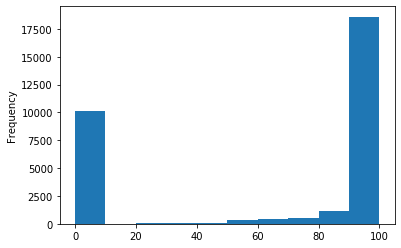

In [95]:
nyc_df_model.host_response_rate.plot('hist')
print("median is:", nyc_df_model.host_response_rate.median())

In [96]:
nyc_df_model['host_response_rate'] = nyc_df_model['host_response_rate'].replace(0,100)

/anaconda3/envs/metis/lib/python3.7/site-packages/ipykernel_launcher.py:1: FutureWarning: `Series.plot()` should not be called with positional arguments, only keyword arguments. The order of positional arguments will change in the future. Use `Series.plot(kind='hist')` instead of `Series.plot('hist',)`.
  """Entry point for launching an IPython kernel.


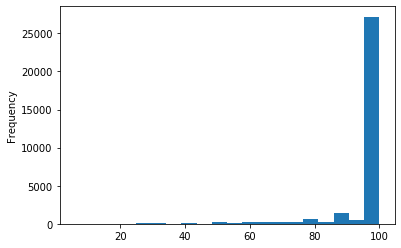

In [97]:
nyc_df_model.host_response_rate.plot('hist', bins=20)

### Convert t/f to Bools? Might just leave as t/f and let dummy coding take care of it
- cancellation_policy       31519 non-null object
- cleaning_fee              31519 non-null bool
- host_identity_verified    31519 non-null object
- instant_bookable          31519 non-null object

# One final look at cols before jumping to models, dummies etc.

In [ ]:
nyc_df_model.describe

In [99]:
nyc_df_model.beds.value_counts()

1.0     21121
2.0     6514 
3.0     2217 
4.0     896  
5.0     379  
6.0     177  
7.0     59   
8.0     35   
10.0    19   
9.0     15   
11.0    7    
12.0    7    
13.0    4    
16.0    4    
15.0    2    
0.0     2    
18.0    1    
Name: beds, dtype: int64

### Final fixes-- cancellation policy. Del the 10 'super strict'

In [100]:
nyc_df_model.cancellation_policy.value_counts()

strict             14038
flexible           9783 
moderate           7688 
super_strict_30    9    
super_strict_60    1    
Name: cancellation_policy, dtype: int64

In [101]:
nyc_df_model.cancellation_policy.replace('super_strict_30', 'strict',inplace=True)

In [102]:
nyc_df_model.cancellation_policy.replace('super_strict_60', 'strict',inplace=True)

In [104]:
nyc_df_model.cancellation_policy.value_counts()

strict      14048
flexible    9783 
moderate    7688 
Name: cancellation_policy, dtype: int64

# Pickle cleaned data

In [105]:
with open ('nyc_df_cleaned.pickle', 'wb') as to_write:
     pickle.dump(nyc_df_model, to_write)